In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

# Evaluation

## Insecure Lockmanager
What follows is the data that was gathered with insecure_lockmanager. 
Contains the time in nanoseconds to acquire n locks 
with two transactions and release them again 
(two worker threads, including one for the transaction table as always).

In [75]:
insecure_simple = pd.read_csv("insecure_simple.csv")

insecure_simple

,locks,nanoseconds
0,10,2115698
1,10,2016608
2,10,1978563
3,10,2066932
4,10,2073231
...,...,...
595,200000,27953962267
596,200000,28214018459
597,200000,28874209571
598,200000,28857125639


The experiment was carried out with different numbers of locks that can be seen below.
Two transactions, A and B, register at the lock manager. A acquires the given number of locks in shared mode, then B acquires the same number of locks. After that A and B release those locks one by one. The time from start to finish is measured in nanoseconds.


In [76]:
numLocks = []
for n in insecure_simple["locks"]:
  if n not in numLocks:
    numLocks.append(n);

numLocks

[10, 100, 500, 1000, 2500, 5000, 10000, 20000, 50000, 100000, 150000, 200000]

The experiment for the same number of locks got repeated several times, up to 100 times for smaller numbers of locks and 50 times for larger numbers of locks (to make the experiments run faster).
The repetition had the purpose of making the time measurements more stable, as it makes it possible to compute the average duration in nanoseconds over the number of repititions carried out.

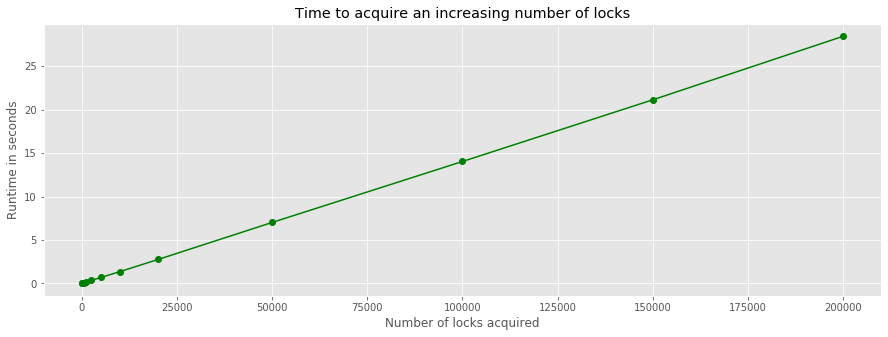

In [77]:
averagesSimple = []
for n in numLocks:
  sum = 0
  count = 0
  for locks, duration in zip(insecure_simple["locks"], insecure_simple["nanoseconds"]):
    if locks == n:
      count += 1
      sum += duration
  averagesSimple.append((sum/count) / 10 ** 9); # average, from nanoseconds to seconds

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)      
ax.plot(numLocks, averagesSimple, "go-")
plt.title("Time to acquire an increasing number of locks")
plt.xlabel("Number of locks acquired")
plt.ylabel("Runtime in seconds")
plt.show()

When we divide the number of locking operations by the time, we get a measurement of throughput.

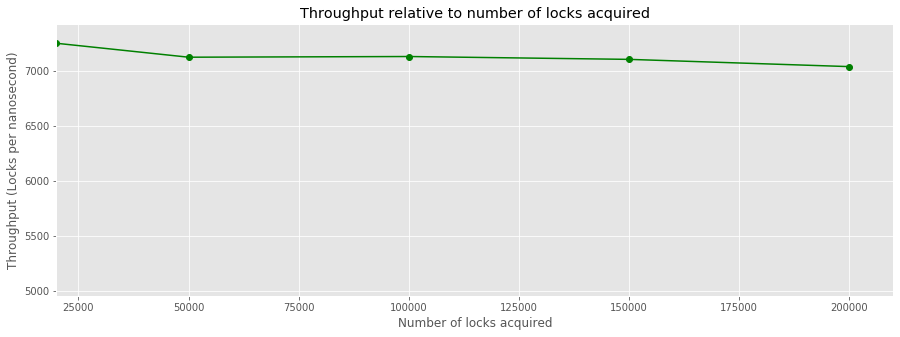

In [78]:
throughputSimple = []
for locks, duration in zip(numLocks, averagesSimple):
  throughputSimple.append(locks / duration)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(numLocks, throughputSimple, "go-")
plt.xlabel("Number of locks acquired")
plt.ylabel("Throughput (Locks per nanosecond)")
plt.title("Throughput relative to number of locks acquired")
plt.xlim(20000)
plt.show()


Now we show the throughput when keeping the number of locks fixed to 60000, but increase the number of worker threads. The worker threads receive jobs to acquire or release a lock and work on a specific portion of the lock table. One thread among the worker threads is always responsible for processing transaction registration requests exclusively though.

In [79]:
insecure_threads = pd.read_csv("insecure_threads.csv")
insecure_threads

,num_threads,locks,nanoseconds
0,2,60000,8497741444
1,2,60000,8705213390
2,2,60000,8606688177
3,2,60000,8793330078
4,2,60000,8581604865
...,...,...,...
195,16,60000,8038821205
196,16,60000,8273075768
197,16,60000,8299723797
198,16,60000,7979684794


In [80]:
numThreads = []
for n in insecure_threads["num_threads"]:
  if n not in numThreads:
    numThreads.append(n);

numThreads

[2, 4, 8, 16]

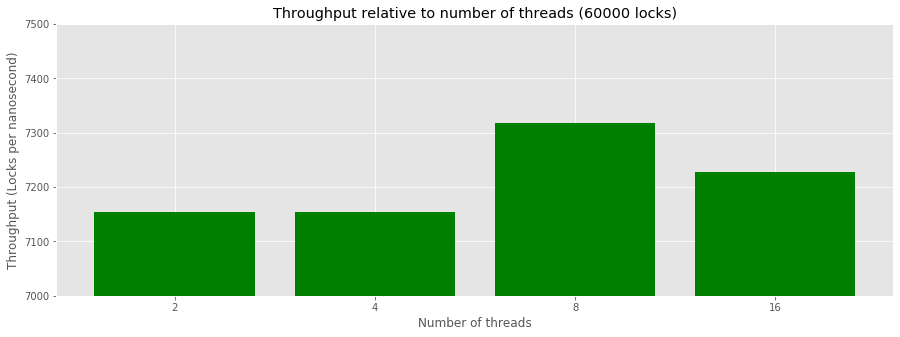

In [81]:
averagesInsecureThreads = []
for n in numThreads:
  sum = 0
  count = 0
  for threads, duration in zip(insecure_threads["num_threads"], insecure_threads["nanoseconds"]):
    if threads == n:
      count += 1
      sum += duration
  averagesInsecureThreads.append((sum/count) / 10 ** 9) # average, from nanoseconds to seconds

throughputInsecureThreads = []
for duration in averagesInsecureThreads:
  throughputInsecureThreads.append(60000 / duration) # always 60000 locks used in the experiment

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.bar(list(map(str, numThreads)), throughputInsecureThreads, color="green")
plt.xlabel("Number of threads")
plt.ylabel("Throughput (Locks per nanosecond)")
plt.title("Throughput relative to number of threads (60000 locks)")
plt.ylim(7000, 7500)
plt.show()

## Demand paging

In [82]:
demand_paging_simple = pd.read_csv("demand_paging_simple.csv")
demand_paging_simple

,locks,nanoseconds
0,10,8468109
1,10,8251669
2,10,7748527
3,10,7005977
4,10,6808882
...,...,...
295,200000,98162601227
296,200000,96300585430
297,200000,95613708852
298,200000,96487098678


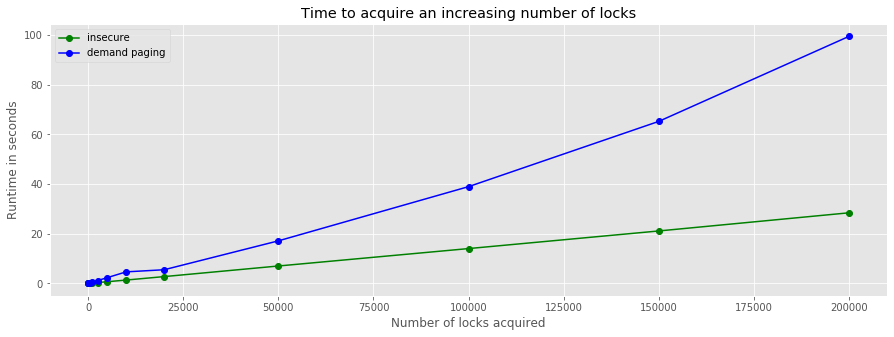

In [83]:
averagesDemandPagingSimple = []
for n in numLocks:
  sum = 0
  count = 0
  for locks, duration in zip(demand_paging_simple["locks"], demand_paging_simple["nanoseconds"]):
    if locks == n:
      count += 1
      sum += duration
  averagesDemandPagingSimple.append((sum/count) / 10 ** 9); # average, from nanoseconds to seconds

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)      
ax.plot(numLocks, averagesSimple, "go-", label="insecure")
ax.plot(numLocks, averagesDemandPagingSimple, "bo-", label="demand paging")
ax.legend()
plt.title("Time to acquire an increasing number of locks")
plt.xlabel("Number of locks acquired")
plt.ylabel("Runtime in seconds")
plt.show()

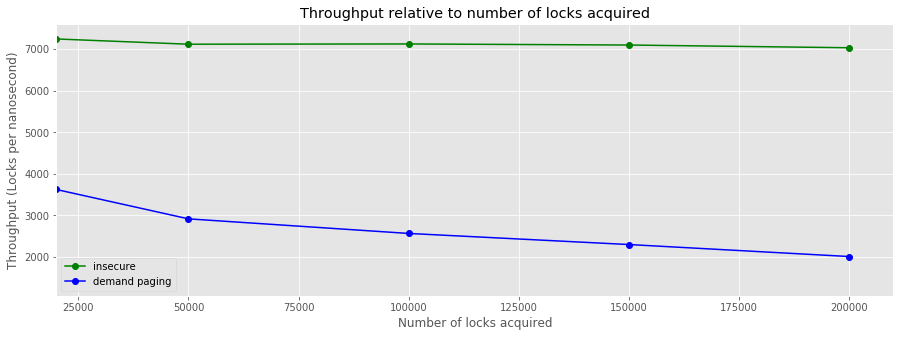

In [84]:
throughputDemandPagingSimple = []
for locks, duration in zip(numLocks, averagesDemandPagingSimple):
  throughputDemandPagingSimple.append(locks / duration)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(numLocks, throughputSimple, "go-", label="insecure")
ax.plot(numLocks, throughputDemandPagingSimple, "bo-", label="demand paging")
ax.legend()
plt.xlabel("Number of locks acquired")
plt.ylabel("Throughput (Locks per nanosecond)")
plt.title("Throughput relative to number of locks acquired")
plt.xlim(20000)
plt.show()

In [85]:
demand_paging_threads = pd.read_csv("demand_paging_threads.csv")
demand_paging_threads

,num_threads,locks,nanoseconds
0,2,60000,32209868186
1,2,60000,33578831996
2,2,60000,34856596985
3,2,60000,33975996577
4,2,60000,34567209823
...,...,...,...
145,8,60000,17415013269
146,8,60000,17696137230
147,8,60000,17638899392
148,8,60000,17694629994


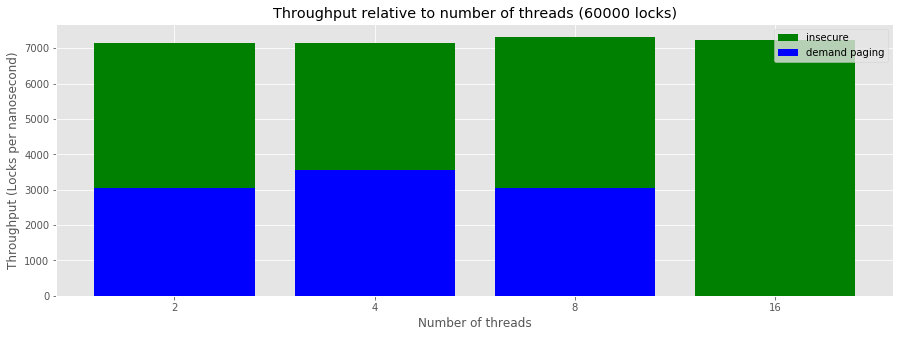

[1364.548005754026,
 1821.60138128681,
 2045.3467612584454,
 2115.8658684904713,
 2132.6960928584895,
 2158.9788720324914,
 2146.9531647711224,
 3625.5272484000484,
 2918.8352988062807,
 2567.6334583068665,
 2300.6113567471634,
 2011.946526191687]

In [86]:
averagesDemandPagingThreads = []
for n in numThreads[:-1]: # exclude 16, because there is no measurement for that
  sum = 0
  count = 0
  for threads, duration in zip(demand_paging_threads["num_threads"], demand_paging_threads["nanoseconds"]):
    if threads == n:
      count += 1
      sum += duration
  averagesDemandPagingThreads.append((sum/count) / 10 ** 9); # average, from nanoseconds to seconds

throughputDemandPagingThreads = []
for duration in averagesDemandPagingThreads:
  throughputDemandPagingThreads.append(60000 / duration) # always 60000 locks used in the experiment
throughputDemandPagingThreads.append(0) # for 16 threads

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.bar(list(map(str, numThreads)), throughputInsecureThreads, color="green", label="insecure")
ax.bar(list(map(str, numThreads)), throughputDemandPagingThreads, color="blue", label="demand paging")
ax.legend()
plt.xlabel("Number of threads")
plt.ylabel("Throughput (Locks per nanosecond)")
plt.title("Throughput relative to number of threads (60000 locks)")
plt.show()
throughputDemandPagingSimple

Performance is already degrading at 8 threads in the enclave implementation in contrast to the insecure variation. So there seems to be additional overhead that poses a tradeoff to the usual performance boost of adding additional threads. One the one hand, a hightened overhead for inter-thread synchronisation in the enclave (making an OCALL necessary) could be contributing to that, on the other hand, the memory for the enclave is more limited, because more Thread Control Structures (TCS) have to be allocated for more threads, that take up space in the enclave and lead to paging in and out of the enclave, when memory limits are reached.

In [87]:
more_tcs = pd.read_csv("demand_paging_simple_big_tcs.csv")
more_tcs

,num_threads,locks,nanoseconds
0,2,10,7264989
1,2,10,6245395
2,2,10,6240053
3,2,10,7251769
4,2,10,5864384
...,...,...,...
570,2,200000,96142592846
571,2,200000,96459488853
572,2,200000,96655620506
573,2,200000,98415820913


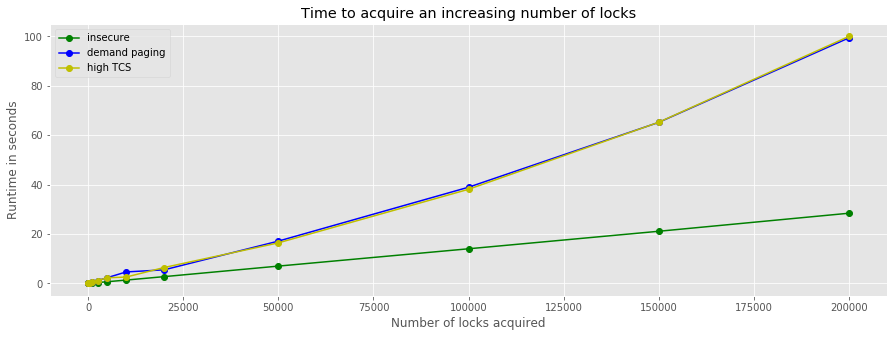

In [89]:
averagesMoreTCS = []
for n in numLocks:
  sum = 0
  count = 0
  for locks, duration in zip(more_tcs["locks"], more_tcs["nanoseconds"]):
    if locks == n:
      count += 1
      sum += duration
  averagesMoreTCS.append((sum/count) / 10 ** 9); # average, from nanoseconds to seconds

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)      
ax.plot(numLocks, averagesSimple, "go-", label="insecure")
ax.plot(numLocks, averagesDemandPagingSimple, "bo-", label="demand paging")
ax.plot(numLocks, averagesMoreTCS, "yo-", label="high TCS")
ax.legend()
plt.title("Time to acquire an increasing number of locks")
plt.xlabel("Number of locks acquired")
plt.ylabel("Runtime in seconds")
plt.show()

The idea here was to still use 2 worker threads, but set TCS=9 to reduce the available memory (?) in the enclave and see if it has an influence on the runtime due to paging. All other parameters stayed the same. It doesn't show a difference, but at least it shows that results are reproducible.